In [71]:
%matplotlib inline

import gmaps
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt

from config import gkey

# Configure gmaps
gmaps.configure(api_key=gkey)
gmaps.figure()

Figure(layout=FigureLayout(height='420px'))

In [3]:
crashes = pd.read_csv("Resources/Traffic_Crashes_-_Crashes.csv", low_memory=False)
crashes.head()

,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,JC190956,NaN,03/19/2019 12:10:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,NOT DIVIDED,...,0.0,0.0,2.0,0.0,0,3,3,41.946678,-87.712656,POINT (-87.712656238768 41.946677671109)
1,JC190951,NaN,03/19/2019 12:05:00 AM,25,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,ONE-WAY,...,0.0,0.0,2.0,0.0,0,3,3,41.882281,-87.750095,POINT (-87.750094540628 41.882281005383)
2,JC190946,NaN,03/18/2019 11:30:00 PM,45,TRAFFIC SIGNAL,NO CONTROLS,CLEAR,DARKNESS,TURNING,ONE-WAY,...,0.0,0.0,2.0,0.0,23,2,3,41.794195,-87.631926,POINT (-87.63192639781 41.794195272036)
3,JC190967,NaN,03/18/2019 11:15:00 PM,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,DARKNESS,REAR END,NOT DIVIDED,...,0.0,0.0,3.0,0.0,23,2,3,41.881892,-87.747898,POINT (-87.747898416744 41.881892308511)
4,JC190923,NaN,03/18/2019 10:45:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,3.0,0.0,22,2,3,41.735964,-87.643682,POINT (-87.643681724352 41.735963647349)


In [4]:
# crashes["CRASH_DATE"].min()
crashes.describe()

,POSTED_SPEED_LIMIT,LANE_CNT,STREET_NO,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
count,279171.000000,1.928170e+05,279171.000000,279167.000000,278651.000000,278130.000000,278130.000000,278130.000000,278130.000000,278130.000000,278130.000000,278130.0,279171.000000,279171.000000,279171.000000,278036.000000,278036.000000
mean,28.165845,1.367694e+01,3576.130411,1244.112746,2.020502,0.154086,0.000877,0.016888,0.082670,0.053651,2.030842,0.0,13.186814,4.126392,6.729818,41.857757,-87.671177
std,6.900461,3.008778e+03,2936.758157,712.925764,0.405019,0.507382,0.032279,0.152116,0.367828,0.295434,1.157985,0.0,5.419958,1.966082,3.593833,0.365009,0.745832
min,0.000000,0.000000e+00,0.000000,111.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,-87.933994
25%,30.000000,2.000000e+00,1161.000000,712.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,9.000000,2.000000,3.000000,41.787254,-87.719934
50%,30.000000,2.000000e+00,3100.000000,1214.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,14.000000,4.000000,7.000000,41.878086,-87.671593
75%,30.000000,4.000000e+00,5501.000000,1824.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,17.000000,6.000000,10.000000,41.924699,-87.632558
max,99.000000,1.191625e+06,451100.000000,2535.000000,18.000000,21.000000,3.000000,7.000000,21.000000,10.000000,61.000000,0.0,23.000000,7.000000,12.000000,42.022780,0.000000


In [23]:
crash_location = crashes.loc[:,"LATITUDE":"LONGITUDE"]
crash_location["LATITUDE"].dropna(how='any', inplace=True)
crash_location["LONGITUDE"].dropna(how='any', inplace=True)
crash_location.rename(columns={"LATITUDE": "Lat", "LONGITUDE":"Lng"}, inplace=True)
crash_location["Region ID"] = ""
crash_location.head()

,Lat,Lng,Region ID
0,41.946678,-87.712656,
1,41.882281,-87.750095,
2,41.794195,-87.631926,
3,41.881892,-87.747898,
4,41.735964,-87.643682,


In [24]:
crash_location.describe()

,Lat,Lng
count,278036.000000,278036.000000
mean,41.857757,-87.671177
std,0.365009,0.745832
min,0.000000,-87.933994
25%,41.787254,-87.719934
50%,41.878086,-87.671593
75%,41.924699,-87.632558
max,42.022780,0.000000


In [25]:
# longitude between -80 and -100
# latitude between 30 and 50
target_url = (f"https://maps.googleapis.com/maps/api/geocode/json?address=Chicago&key={gkey}")
geo_data = requests.get(target_url).json()
print(json.dumps(geo_data, indent=4, sort_keys=True))

{
    "results": [
        {
            "address_components": [
                {
                    "long_name": "Chicago",
                    "short_name": "Chicago",
                    "types": [
                        "locality",
                        "political"
                    ]
                },
                {
                    "long_name": "Cook County",
                    "short_name": "Cook County",
                    "types": [
                        "administrative_area_level_2",
                        "political"
                    ]
                },
                {
                    "long_name": "Illinois",
                    "short_name": "IL",
                    "types": [
                        "administrative_area_level_1",
                        "political"
                    ]
                },
                {
                    "long_name": "United States",
                    "short_name": "US",
                    "types": [
 

In [26]:
lat_min = geo_data['results'][0]['geometry']['bounds']['southwest']['lat']
lat_max = geo_data['results'][0]['geometry']['bounds']['northeast']['lat']
lng_min = geo_data['results'][0]['geometry']['bounds']['southwest']['lng']
lng_max = geo_data['results'][0]['geometry']['bounds']['northeast']['lng']
print(f"Illinois spans latitude {lat_min} to {lat_max}.")
print(f"Illinois spans longitude {lng_min} to {lng_max}.")
print("We will need to discard any errant data that falls outside these bounds.")

Illinois spans latitude 41.6443349 to 42.023131.
Illinois spans longitude -87.9402669 to -87.52366099999999.
We will need to discard any errant data that falls outside these bounds.


In [27]:
i = 0
for index, row in crash_location.iterrows():
    if (crash_location["Lat"][index] < lat_min) | (crash_location["Lat"][index] > lat_max) | (np.isnan(crash_location["Lat"][index])) | (crash_location["Lng"][index] < lng_min) | (crash_location["Lng"][index] > lng_max) | (np.isnan(crash_location["Lng"][index])):
        print(f"Out of bounds: lat/lng {crash_location['Lat'][index]}, {crash_location['Lng'][index]}. Dropping record...")
        crash_location.drop(index, inplace=True)
        i += 1
print(f"Cleaning complete: {i} rows were dropped due to lat/lng outside bounds.")

Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bound

Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bound

Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bound

Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bound

Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bound

Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bound

Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bound

Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bound

In [10]:
crash_location.describe()

,Lat,Lng
count,278016.000000,278016.000000
mean,41.860768,-87.677484
std,0.084798,0.057699
min,41.644670,-87.933994
25%,41.787269,-87.719936
50%,41.878097,-87.671603
75%,41.924702,-87.632561
max,42.022780,-87.524587


In [17]:
regions = pd.read_csv("Resources/Chicago_Traffic_Tracker_-_Congestion_Estimates_by_Regions.csv", low_memory=False)
regions.head()
regions.describe()

,REGION_ID,WEST,EAST,SOUTH,NORTH,CURRENT_SPEED
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,15.000000,-87.701910,-87.642355,41.824520,41.867706,22.871379
std,8.514693,0.068858,0.063614,0.099126,0.096047,4.484596
min,1.000000,-87.846210,-87.747456,41.644139,41.677477,12.270000
25%,8.000000,-87.747456,-87.674590,41.764066,41.822792,20.450000
50%,15.000000,-87.685372,-87.646438,41.822792,41.866129,23.180000
75%,22.000000,-87.647208,-87.606334,41.909269,41.931841,25.230000
max,29.000000,-87.584845,-87.524436,41.997946,42.026444,32.730000


In [20]:
region_location = regions.loc[:," REGION_ID":" NORTH"]
region_location.head()

,REGION_ID,WEST,EAST,SOUTH,NORTH
0,25,-87.747456,-87.662508,41.677477,41.728472
1,21,-87.606334,-87.566260,41.764066,41.822792
2,9,-87.775947,-87.747456,41.866129,41.909269
3,18,-87.747456,-87.683730,41.764066,41.822792
4,8,-87.674590,-87.619112,41.910561,41.960669


In [38]:
for index, row in crash_location.iterrows():
    for index2, row2 in region_location.iterrows():
        if ((crash_location["Lat"][index] < region_location[" NORTH"][index2]) & (crash_location["Lat"][index] > region_location[" SOUTH"][index2]) & (crash_location["Lng"][index] > region_location[" WEST"][index2]) & (crash_location["Lng"][index] < region_location[" EAST"][index2])):
            crash_location["Region ID"][index] = region_location[" REGION_ID"][index2]
crash_location.head()

,Lat,Lng,Region ID
0,41.946678,-87.712656,6
1,41.882281,-87.750095,9
2,41.794195,-87.631926,20
3,41.881892,-87.747898,9
4,41.735964,-87.643682,23


In [57]:
crash_final = crash_location['Region ID'].value_counts().to_frame()
crash_final.rename(columns={'Region ID': "crash_count"}, inplace=True)
crash_final

,crash_count
,232963
18,2951
11,2697
5,2653
10,2449
8,2314
13,2155
3,2048
6,2047
23,1945


In [41]:
rl_cams = pd.read_csv("Resources/Red_Light_Camera_Locations.csv", low_memory=False)
rl_cams.head()

,INTERSECTION,FIRST APPROACH,SECOND APPROACH,THIRD APPROACH,GO LIVE DATE,LATITUDE,LONGITUDE,LOCATION
0,Pulaski-Diversey,SB,NB,NaN,05/15/2009,41.931791,-87.726979,"(41.931791, -87.726979)"
1,Pulaski-Foster,SB,WB,NaN,10/18/2007,41.975532,-87.728234,"(41.975532, -87.728234)"
2,Cicero-Fullerton,SB,WB,NaN,02/25/2006,41.924237,-87.746302,"(41.924237, -87.746302)"
3,Harlem-Belmont,NB,WB,NaN,06/18/2007,41.937997,-87.806746,"(41.937997, -87.806746)"
4,Narragansett-Fullerton,EB,WB,NaN,11/14/2008,41.923676,-87.785441,"(41.923676, -87.785441)"


In [44]:
rl_location = rl_cams.loc[:,"LATITUDE":"LONGITUDE"]
rl_location["LATITUDE"].dropna(how='any', inplace=True)
rl_location["LONGITUDE"].dropna(how='any', inplace=True)
rl_location.rename(columns={"LATITUDE": "Lat", "LONGITUDE":"Lng"}, inplace=True)
rl_location["Region ID"] = ""
rl_location.head()

,Lat,Lng,Region ID
0,41.931791,-87.726979,
1,41.975532,-87.728234,
2,41.924237,-87.746302,
3,41.937997,-87.806746,
4,41.923676,-87.785441,


In [45]:
for index, row in rl_location.iterrows():
    for index2, row2 in region_location.iterrows():
        if ((rl_location["Lat"][index] < region_location[" NORTH"][index2]) & (rl_location["Lat"][index] > region_location[" SOUTH"][index2]) & (rl_location["Lng"][index] > region_location[" WEST"][index2]) & (rl_location["Lng"][index] < region_location[" EAST"][index2])):
            rl_location["Region ID"][index] = region_location[" REGION_ID"][index2]
rl_location.head()

C:\Users\Robert\AppData\Local\Continuum\anaconda3\envs\PythonData2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Lat,Lng,Region ID
0,41.931791,-87.726979,7
1,41.975532,-87.728234,3
2,41.924237,-87.746302,7
3,41.937997,-87.806746,5
4,41.923676,-87.785441,5


In [59]:
rl_final = rl_location['Region ID'].value_counts().to_frame()
rl_final.rename(columns={'Region ID': "red_light_camera_count"}, inplace=True)
rl_final

,red_light_camera_count
5,15
7,14
6,13
18,12
10,10
3,10
11,9
8,8
2,7
14,6


In [47]:
speed_cams = pd.read_csv("Resources/Speed_Camera_Locations.csv", low_memory=False)
speed_cams.head()

,ADDRESS,FIRST APPROACH,SECOND APPROACH,GO-LIVE DATE,LATITUDE,LONGITUDE,LOCATION
0,3843 W 111th (Speed Camera),EB,WB,01/13/2014,41.691202,-87.717211,"(41.69120239624487, -87.71721139909997)"
1,19 W Chicago Ave (Speed Camera),WB,NaN,04/29/2014,41.896556,-87.629026,"(41.89655610710888, -87.62902590382873)"
2,2445 W 51st St (Speed Camera),EB,NaN,02/24/2014,41.801013,-87.686071,"(41.801012880525555, -87.68607060493738)"
3,7739 S Western (Speed Camera),NB,NaN,12/18/2013,41.752629,-87.682765,"(41.752629293489285, -87.68276525603093)"
4,3832 W 79th St (Speed Camera),EB,NaN,02/10/2014,41.749715,-87.719599,"(41.749715176851936, -87.71959877920995)"


In [48]:
speed_location = speed_cams.loc[:,"LATITUDE":"LONGITUDE"]
speed_location["LATITUDE"].dropna(how='any', inplace=True)
speed_location["LONGITUDE"].dropna(how='any', inplace=True)
speed_location.rename(columns={"LATITUDE": "Lat", "LONGITUDE":"Lng"}, inplace=True)
speed_location["Region ID"] = ""
speed_location.head()

,Lat,Lng,Region ID
0,41.691202,-87.717211,
1,41.896556,-87.629026,
2,41.801013,-87.686071,
3,41.752629,-87.682765,
4,41.749715,-87.719599,


In [49]:
for index, row in speed_location.iterrows():
    for index2, row2 in region_location.iterrows():
        if ((speed_location["Lat"][index] < region_location[" NORTH"][index2]) & (speed_location["Lat"][index] > region_location[" SOUTH"][index2]) & (speed_location["Lng"][index] > region_location[" WEST"][index2]) & (speed_location["Lng"][index] < region_location[" EAST"][index2])):
            speed_location["Region ID"][index] = region_location[" REGION_ID"][index2]
speed_location.head()

C:\Users\Robert\AppData\Local\Continuum\anaconda3\envs\PythonData2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Lat,Lng,Region ID
0,41.691202,-87.717211,25
1,41.896556,-87.629026,12
2,41.801013,-87.686071,18
3,41.752629,-87.682765,22
4,41.749715,-87.719599,22


In [60]:
speed_final = speed_location['Region ID'].value_counts().to_frame()
speed_final.rename(columns={'Region ID': "speed_camera_count"}, inplace=True)
speed_final

,speed_camera_count
18,22
5,16
10,14
3,10
6,10
11,8
22,8
8,8
15,7
2,7


In [70]:
merged_1 = crash_final.merge(rl_final, how='outer', left_index=True, right_index=True)
merged_df = merged_1.merge(speed_final, how='outer', left_index=True, right_index=True)
merged_df.fillna(0,inplace=True)
merged_df

,crash_count,red_light_camera_count,speed_camera_count
,232963,0.0,0.0
18,2951,12.0,22.0
11,2697,9.0,8.0
5,2653,15.0,16.0
10,2449,10.0,14.0
8,2314,8.0,8.0
13,2155,4.0,2.0
3,2048,10.0,10.0
6,2047,13.0,10.0
23,1945,6.0,6.0


Text(0, 0.5, 'Traffic Crashes')

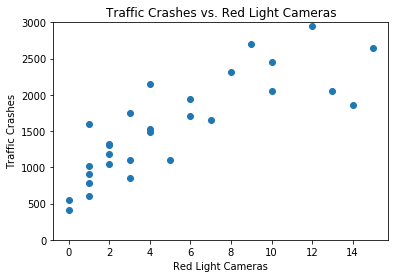

In [75]:
plt.scatter(merged_df['red_light_camera_count'],merged_df['crash_count'])
plt.ylim(0,3000)
plt.title("Traffic Crashes vs. Red Light Cameras")
plt.xlabel("Red Light Cameras")
plt.ylabel("Traffic Crashes")

Text(0, 0.5, 'Traffic Crashes')

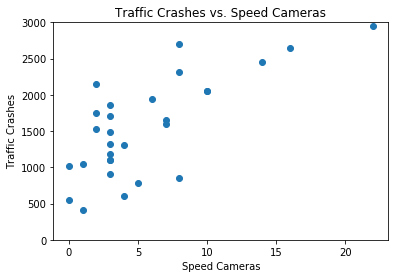

In [76]:
plt.scatter(merged_df['speed_camera_count'],merged_df['crash_count'])
plt.ylim(0,3000)
plt.title("Traffic Crashes vs. Speed Cameras")
plt.xlabel("Speed Cameras")
plt.ylabel("Traffic Crashes")